In [4]:

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
DATA_PATH = "MOCK_NHANES_2021_2023_DIABETES.csv"

In [14]:
FORCE = {}

In [47]:
CANDIDATES = {
    "SEQN":       ["SEQN","id","ID","participant_id"],
    "HbA1c":      ["LBXGH","HbA1c","A1C","hba1c","HbA1c_percent","HbA1C"],
    "Glucose":    ["LBXGLU","Glucose","glucose","FPG","fasting_glucose","Glucose_mg_dL"],
    "Insulin":    ["LBXIN","Insulin","insulin","insulin_uU_mL","Insulin_uU_mL"],
    "Trig":       ["LBXTR","Triglycerides","triglycerides","trig","Triglycerides_mg_dL"],
    "HDL":        ["LBDHDD","HDL","hdl","HDL_mg_dL"],
    "FastingFlag":["PHAFST","fasting","is_fasting","Fasting","Fasted"],
    "FastingHr":  ["PHAFSTHR","fasting_hours","FastingHours"],
    "FastingMin": ["PHAFSTMN","fasting_minutes","FastingMinutes"],
    "Age":        ["RIDAGEYR","Age","age"],
    "Sex":        ["RIAGENDR","sex","Sex","Gender","gender"],
    "Race":       ["RIDRETH3","race","Race"],
    "Weight":     ["WTMEC2YR","weight","Weight"]
}

In [48]:
def find_col(df, keys, force_name=None):
    """Return the first matching column in df for the semantic key."""
    if force_name and force_name in df.columns:
        return force_name
    for cand in CANDIDATES[keys]:
        if cand in df.columns:
            return cand
    return None

In [49]:
# =========================================
# 3) Load data (CSV or Excel)
# =========================================
ext = os.path.splitext(DATA_PATH)[1].lower()
if ext in [".xlsx", ".xls"]:
    df = pd.read_excel(DATA_PATH)
else:
    df = pd.read_csv(DATA_PATH)

# Work with a copy
df0 = df.copy()

In [50]:
# =========================================
# 4) Map columns (auto + FORCE overrides)
# =========================================
colmap = {}
for k in CANDIDATES:
    forced = FORCE.get(k)
    colmap[k] = find_col(df0, k, force_name=forced)

print("Detected columns:")
for k,v in colmap.items():
    print(f"  {k:12s} -> {v}")


Detected columns:
  SEQN         -> SEQN
  HbA1c        -> LBXGH
  Glucose      -> LBXGLU
  Insulin      -> LBXIN
  Trig         -> LBXTR
  HDL          -> LBDHDD
  FastingFlag  -> PHAFST
  FastingHr    -> PHAFSTHR
  FastingMin   -> PHAFSTMN
  Age          -> RIDAGEYR
  Sex          -> RIAGENDR
  Race         -> RIDRETH3
  Weight       -> WTMEC2YR


In [51]:
# Convenient refs
col_a1c   = colmap["HbA1c"]
col_glu   = colmap["Glucose"]
col_ins   = colmap["Insulin"]
col_trig  = colmap["Trig"]
col_hdl   = colmap["HDL"]
col_fast  = colmap["FastingFlag"]

In [52]:
# =========================================
# 5) Derive TyG & HOMA-IR if possible
# TyG = ln(Triglycerides * Glucose / 2)
# HOMA-IR = (Insulin * Glucose) / 405  (commonly for fasting)
# =========================================
if "TyG" not in df0.columns and col_trig and col_glu:
    try:
        df0["TyG"] = np.log((df0[col_trig].astype(float) * df0[col_glu].astype(float)) / 2.0)
    except Exception:
        df0["TyG"] = np.nan

if "HOMA_IR" not in df0.columns and col_ins and col_glu:
    try:
        homa_raw = (df0[col_ins].astype(float) * df0[col_glu].astype(float)) / 405.0
        if col_fast and df0[col_fast].dropna().isin([1,True,"true","True","Yes","yes"]).any():
            # apply fasting-only rule when a fasting flag exists
            fast_mask = df0[col_fast].isin([1,True,"true","True","Yes","yes"])
            df0["HOMA_IR"] = np.where(fast_mask, homa_raw, np.nan)
        else:
            # fallback: no fasting flag, provide raw HOMA_IR
            df0["HOMA_IR"] = homa_raw
    except Exception:
        df0["HOMA_IR"] = np.nan


In [53]:
# =========================================
# 6) Build an ADA-like category (optional)
# HbA1c: <5.7 normal, 5.7–6.4 prediabetes, >=6.5 diabetes
# FPG:   <100 normal, 100–125 prediabetes, >=126 diabetes
# If both exist, we mark diabetes if either meets diabetes criterion, else prediabetes if either meets prediabetes
# =========================================
def gly_cat(row):
    a1c = row[col_a1c] if col_a1c else np.nan
    glu = row[col_glu] if col_glu else np.nan
    # Diabetes?
    if (pd.notna(a1c) and a1c >= 6.5) or (pd.notna(glu) and glu >= 126):
        return "diabetes"
    # Prediabetes?
    if ((pd.notna(a1c) and 5.7 <= a1c < 6.5) or (pd.notna(glu) and 100 <= glu < 126)):
        return "prediabetes"
    # Otherwise
    if pd.isna(a1c) and pd.isna(glu):
        return np.nan
    return "normal"

if (col_a1c or col_glu) and "DX_CAT" not in df0.columns:
    df0["DX_CAT"] = df0.apply(gly_cat, axis=1)

In [54]:
# =========================================
# 7) PLOTTING (matplotlib, single-plot figures)
# =========================================
def ensure_numeric(series):
    return pd.to_numeric(series, errors="coerce")


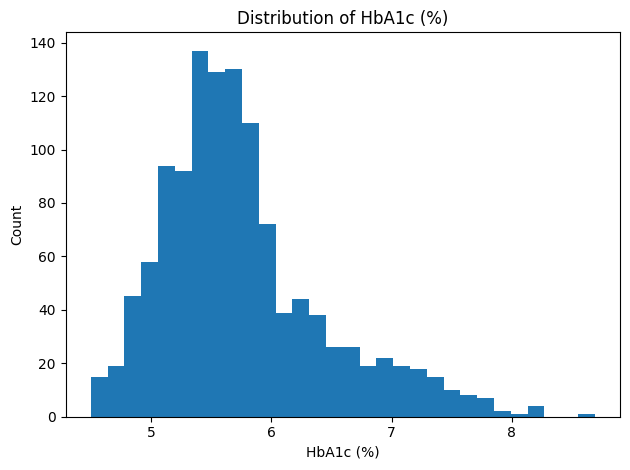

In [55]:
# 7a) HbA1c histogram
if col_a1c:
    plt.figure()
    plt.hist(ensure_numeric(df0[col_a1c]).dropna(), bins=30)
    plt.title("Distribution of HbA1c (%)")
    plt.xlabel("HbA1c (%)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


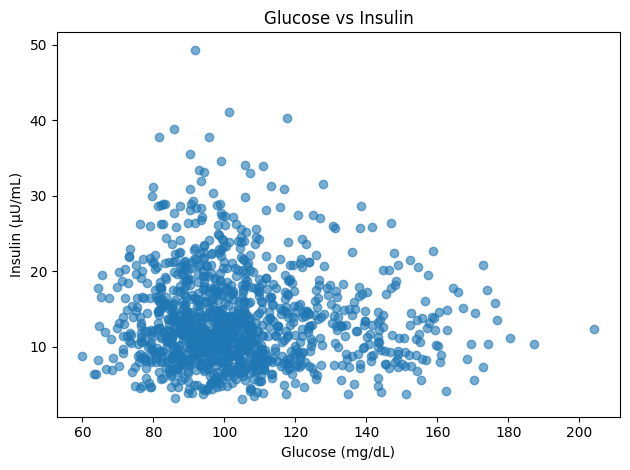

In [56]:
# 7b) Glucose vs Insulin
if col_glu and col_ins:
    plt.figure()
    plt.scatter(ensure_numeric(df0[col_glu]), ensure_numeric(df0[col_ins]), alpha=0.6)
    plt.title("Glucose vs Insulin")
    plt.xlabel("Glucose (mg/dL)")
    plt.ylabel("Insulin (µU/mL)")
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-1567844255.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_box, labels=labels, showfliers=False)


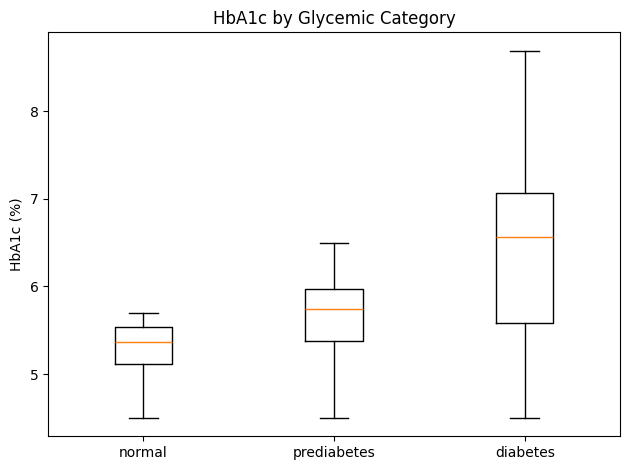

In [57]:
# 7c) HbA1c by category boxplot
if "DX_CAT" in df0.columns and col_a1c:
    plt.figure()
    cats = ["normal","prediabetes","diabetes"]
    data_box = [ensure_numeric(df0.loc[df0["DX_CAT"]==c, col_a1c]).dropna() for c in cats]
    labels = [c for c,d in zip(cats, data_box) if len(d)>0]
    data_box = [d for d in data_box if len(d)>0]
    if data_box:
        plt.boxplot(data_box, labels=labels, showfliers=False)
        plt.title("HbA1c by Glycemic Category")
        plt.ylabel("HbA1c (%)")
        plt.tight_layout()
        plt.show()

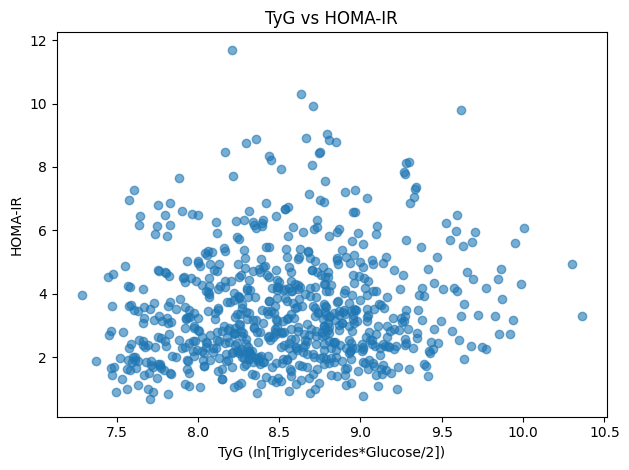

In [58]:

# 7d) TyG vs HOMA-IR
if "TyG" in df0.columns and "HOMA_IR" in df0.columns:
    mask = df0["TyG"].notna() & df0["HOMA_IR"].notna()
    if mask.any():
        plt.figure()
        plt.scatter(df0.loc[mask,"TyG"], df0.loc[mask,"HOMA_IR"], alpha=0.6)
        plt.title("TyG vs HOMA-IR")
        plt.xlabel("TyG (ln[Triglycerides*Glucose/2])")
        plt.ylabel("HOMA-IR")
        plt.tight_layout()
        plt.show()

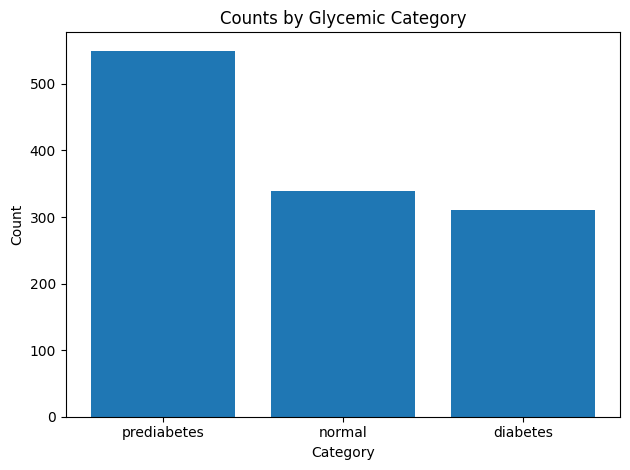

In [59]:
# 7e) Category counts
if "DX_CAT" in df0.columns:
    plt.figure()
    counts = df0["DX_CAT"].value_counts(dropna=True)
    plt.bar(counts.index.astype(str), counts.values)
    plt.title("Counts by Glycemic Category")
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


In [60]:
# Suppose your DataFrame is called df (from CSV/Excel)
# Rename NHANES-style variable names into human-friendly labels

rename_map = {
    "SEQN": "ID",
    "RIDAGEYR": "Age_Years",
    "RIAGENDR": "Sex",             # 1=Male, 2=Female
    "RIDRETH3": "Race_Ethnicity",
    "SDMVSTRA": "Survey_Stratum",
    "SDMVPSU": "Survey_PSU",
    "WTMEC2YR": "Sample_Weight",
    "PHAFST": "Fasting_Status",    # 1=Yes, 0=No
    "PHAFSTHR": "Fasting_Hours",
    "PHAFSTMN": "Fasting_Minutes",
    "LBXGLU": "Glucose_mg_dL",
    "LBXGH": "HbA1c_percent",
    "LBXIN": "Insulin_uU_mL",
    "LBXTR": "Triglycerides_mg_dL",
    "LBDHDD": "HDL_mg_dL",
    "TyG": "TyG_Index",
    "HOMA_IR": "HOMA_IR_Index",
    "DX_CAT": "Glycemic_Category"
}

df = df.rename(columns=rename_map)

# Preview first few rows with clean names
print(df.head())


       ID  Age_Years  Sex  Race_Ethnicity  Survey_Stratum  Survey_PSU  \
0  100000         53    2               2              11           2   
1  100001         43    1               7               7           3   
2  100002         56    2               3              15           4   
3  100003         71    1               4              10           3   
4  100004         41    1               4              10           1   

   Sample_Weight  Fasting_Status  Fasting_Hours  Fasting_Minutes  \
0       1.295433               1           10.9               49   
1       0.807355               0            2.4               40   
2       1.589283               1            9.6               12   
3       1.121332               1           10.5                5   
4       1.403907               1           15.0               49   

   Glucose_mg_dL  HbA1c_percent  Insulin_uU_mL  Triglycerides_mg_dL  \
0          109.7           8.26          17.92                150.3   
1         